### Test graphcut, 

#### Initial imports

In [79]:
import os
import shutil
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import nibabel as nib
from scipy.ndimage import morphology
import SimpleITK

# import scipy.ndimage
# from skimage import morphology



gradient.shape:  (2, 256)
number of axes:  6
number of axes:  6


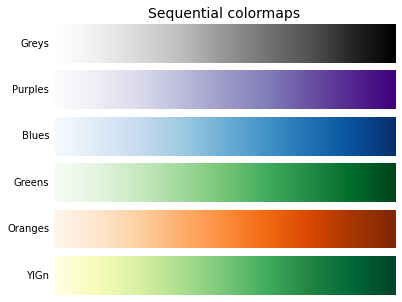

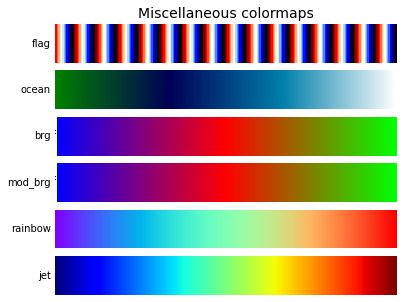

In [80]:
#Modified from https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict

cmaps = OrderedDict()
cmaps['Sequential'] = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'YlGn']
cmaps['Miscellaneous'] = ['flag',  'ocean', 'brg', 'mod_brg', 'rainbow', 'jet']
#cmaps.items()
# for cmap_category, cmap_list in cmaps.items():
#     print(cmap_category)
#     print(cmap_list)
nrows = max(len(cmap_list) for cmap_category, cmap_list in cmaps.items())
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
print('gradient.shape: ', gradient.shape)

def plot_color_gradients(cmap_category, cmap_list, nrows):
    fig, axes = plt.subplots(nrows=nrows)
    print('number of axes: ', len(axes))
    fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
    axes[0].set_title(cmap_category + ' colormaps', fontsize=14)

    for ax, name in zip(axes, cmap_list):
        if name == 'mod_brg':
            #cmap=plt.get_cmap(name)
            cmap = plt.cm.get_cmap('brg')
            cmap._init()
            #print('lut shape :', colormap._lut.shape)
            #print('before setup:')
            #print(cmap._lut[0:10, :])
            cmap._lut[:1:,3]=0
            #print('after setup:')
            #print(cmap._lut[0:10, :])        
        else:
            #cmap=plt.get_cmap(name)
            cmap = plt.cm.get_cmap(name)
        ax.imshow(gradient, aspect='auto', cmap=cmap)
        pos = list(ax.get_position().bounds)
        x_text = pos[0] - 0.01
        y_text = pos[1] + pos[3]/2.
        fig.text(x_text, y_text, name, va='center', ha='right', fontsize=10)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axes:
        ax.set_axis_off()

for cmap_category, cmap_list in cmaps.items():
    plot_color_gradients(cmap_category, cmap_list, nrows)
plt.show() 




In [82]:
ht = np.zeros((5,20,20), dtype=np.uint8)
ht[1, 4:11, 6:10]=1
ht[2, 7:17, 2:17]=1
ht[3, 3:10, 7:12]=1
print('Sum ', np.sum(ht))

fractionDivider = 2
misclassifiedRegion = np.zeros([2, 16, 16], dtype=np.uint8)
misclassifiedRegion[0, 5:7,5:7] = 1
misclassifiedRegion[1, 9, 10:12] = 1

onePixelsThisVol = np.where(misclassifiedRegion)
onePixelCoordsThisVol = list(zip(onePixelsThisVol[0], onePixelsThisVol[1], onePixelsThisVol[2]))
print(onePixelCoordsThisVol)
numOnePixelCoordsThisVol = len(onePixelCoordsThisVol)
#Debug:
print('numOnePixelCoordsThisVol ', numOnePixelCoordsThisVol)
numScribblesFromThisVol = numOnePixelCoordsThisVol // fractionDivider
chosenScribbleCoordsThisVol = random.sample(onePixelCoordsThisVol, numScribblesFromThisVol)
print(chosenScribbleCoordsThisVol)

#for coord in chosenScribbleCoordsThisVol : resultBinary[coord] = 1 

Sum  213
[(0, 5, 5), (0, 5, 6), (0, 6, 5), (0, 6, 6), (1, 9, 10), (1, 9, 11)]
numOnePixelCoordsThisVol  6
[(1, 9, 10), (0, 5, 5), (0, 6, 6)]


In [83]:
# some list - tuple generation, conversion
sliceId = 1
A = (4,10)
B = [sliceId]
C = tuple(B + list(A))
# print(A)
# print(B)
# print(C)

D = [(4, 1), (6, 6), (3, 5)]
E = [ tuple([sliceId] + list(tupleElem)) for  tupleElem in D]
#print(E)

F = np.zeros([2, 10, 10], dtype=np.uint8)
for coord in E : F[coord] = 1
#print(F)
print(max(10-3, 0))
print(min(126+4, 128))

7
128


In [84]:
#Understand Bounding box function
#Rewriting: https://stackoverflow.com/questions/31400769/bounding-box-of-numpy-array
def bbox2_3D(img, expandBBoxFlag=False, pad=0):
    """
    In 3D np array assuming:
    - first axis is slice, -> axial plane index
    - 2nd axis row in each slice, -> coronal plane index
    - last axis is column in each slice -> sagittal plane index
    """
    #np.any will search for non zero elemens in the axis mentioned 
    #So if axis=(1,2): Axial plane, it will search over axis (1=row and 2=col) and return  result
    #for each slice - axial plane
    nonZeroAxialPlanes = np.any(img, axis=(1, 2))
    #So if axis=(0,2) - Corronal plane, it will search over axis (0=slice and 2=col) and return  result
    #for corronal plane
    nonZeroCoronalPlanes = np.any(img, axis=(0, 2))
    #So if axis=(0,1)- sagittal plane, it will search over axis (0=slice and 1=row) and return  result
    #for each sagittal plane
    nonZeroSagittalPlanes = np.any(img, axis=(0, 1))
    
    #result from np.any(): [False  True  True  True False]
    #result of applying np.where() : (array([ 1,2,3]),)
    #So its a tuple of 1-D array on which one applies [0][[0, -1]]
    #The first [0] takes the first array element out of the tuple
    #The next [[0,-1]] is using list based indexing and getting the first and last element out

    axial_min, axial_max = np.where(nonZeroAxialPlanes)[0][[0, -1]]
    coronal_min, coronal_max = np.where(nonZeroCoronalPlanes)[0][[0, -1]]
    sagittal_min, sagittal_max = np.where(nonZeroSagittalPlanes)[0][[0, -1]]
    
    if True == expandBBoxFlag:
        axial_min = max(axial_min-pad,0)
        axial_max = min(axial_max+pad,img.shape[0]-1)
        coronal_min = max(coronal_min-pad,0)
        coronal_max = min(coronal_max+pad,img.shape[1]-1)        
        sagittal_min = max(sagittal_min-pad,0)
        sagittal_max = min(sagittal_max+pad,img.shape[2]-1)
    return axial_min, axial_max, coronal_min, coronal_max, sagittal_min, sagittal_max

#Test code
img = np.zeros((8,20,20), dtype=np.uint8)
img[1, 4:11, 6:10]=1
img[4, 7:14, 2:13]=1
img[5, 3:10, 7:12]=1

axial_min, axial_max, coronal_min, coronal_max, sagittal_min, sagittal_max =\
    bbox2_3D(img)
print(axial_min, axial_max, coronal_min, coronal_max, sagittal_min, sagittal_max)
axial_min, axial_max, coronal_min, coronal_max, sagittal_min, sagittal_max =\
    bbox2_3D(img, expandBBoxFlag=True, pad=1)
print(axial_min, axial_max, coronal_min, coronal_max, sagittal_min, sagittal_max)
axial_min, axial_max, coronal_min, coronal_max, sagittal_min, sagittal_max =\
    bbox2_3D(img, expandBBoxFlag=True, pad=4)
print(axial_min, axial_max, coronal_min, coronal_max, sagittal_min, sagittal_max)

1 5 3 13 2 12
0 6 2 14 1 13
0 7 0 17 0 16


In [85]:
def getUnionBoundingBoxWithPadding(gt, pred, bbPad):
    """
    gt: volume 1; 1st dim: slice; 2nd dim: row; 3rd dim col
    pred: volume 2 of same shape as gt
    bbPad: Padding amount to be added over union
    
    return: bounding box limits (inclusive on both end)
    """
    #In BB calculation: a : axial, c: corronal, s : sagittal
    #BB around  GT
    a_min_g, a_max_g, c_min_g, c_max_g, s_min_g, s_max_g = bbox2_3D(gt, expandBBoxFlag=False, pad=0)
    #BB around  pred
    a_min_p, a_max_p, c_min_p, c_max_p, s_min_p, s_max_p = bbox2_3D(pred, expandBBoxFlag=False, pad=0)
    #common BB encompassing both GT and pred  and padding added
    a_min, a_max, c_min, c_max, s_min, s_max = \
            min(a_min_g, a_min_p), max(a_max_g, a_max_p),\
            min(c_min_g, c_min_p), max(c_max_g, c_max_p),\
            min(s_min_g, s_min_p), max(s_max_g, s_max_p)   
    #After added padding: Note both GT and Pred has the same shape
    a_min = max(a_min-bbPad,0)
    a_max = min(a_max+bbPad,     gt.shape[0]-1)
    c_min = max(c_min-bbPad,0)
    c_max = min(c_max+bbPad,   gt.shape[1]-1)        
    s_min = max(s_min-bbPad,0)
    s_max = min(s_max+bbPad,  gt.shape[2]-1) 
    return a_min, a_max, c_min, c_max, s_min, s_max

gt = np.zeros((8,20,20), dtype=np.uint8)
gt[3, 6:11, 9:10]=1
gt[4, 7:13,10:13]=1
gt[5, 4:10, 11:19]=1
a_min_g, a_max_g, c_min_g, c_max_g, s_min_g, s_max_g = bbox2_3D(gt, expandBBoxFlag=False, pad=0)
print(a_min_g, a_max_g, c_min_g, c_max_g, s_min_g, s_max_g)

pred = np.zeros((8,20,20), dtype=np.uint8)
pred[4, 11:13, 5:15]=1
pred[5, 12:10, 7:12]=1
pred[6, 13:14, 6:10]=1 
a_min_p, a_max_p, c_min_p, c_max_p, s_min_p, s_max_p = bbox2_3D(pred, expandBBoxFlag=False, pad=0)
print(a_min_p, a_max_p, c_min_p, c_max_p, s_min_p, s_max_p)

#common with padding
bbPad=2
a_min, a_max, c_min, c_max, s_min, s_max = getUnionBoundingBoxWithPadding(gt, pred, bbPad)
print(a_min, a_max, c_min, c_max, s_min, s_max)
bbVolume = np.zeros_like(gt)
#Note the +1 without which we were notmaking the highest limit 1
bbVolume[a_min:a_max+1, c_min:c_max+1, s_min:s_max+1]=1
print(bbox2_3D(bbVolume, expandBBoxFlag=False, pad=0))

3 5 4 12 9 18
4 6 11 13 5 14
1 7 2 15 3 19
(1, 7, 2, 15, 3, 19)


In [86]:
#Method to create 2D-disk and 3D ball to be used for fat scribble
def disk(n):
    struct = np.zeros((2 * n + 1, 2 * n + 1))
    x, y = np.indices((2 * n + 1, 2 * n + 1))
    mask = (x - n)**2 + (y - n)**2 <= n**2
    struct[mask] = 1
    return struct.astype(np.bool)

def ball(n):
    struct = np.zeros((2*n+1, 2*n+1, 2*n+1))
    x, y, z = np.indices((2*n+1, 2*n+1, 2*n+1))
    mask = (x - n)**2 + (y - n)**2 + (z - n)**2 <= n**2
    struct[mask] = 1
    return struct.astype(np.bool)

In [87]:
# Test disk
G = np.zeros([16, 16], dtype=np.uint8)
G[5:13,4:7] = 1
dilated_G = scipy.ndimage.binary_dilation(G,structure=disk(2)).astype(G.dtype)

# print('G')
# print(G)
# print('dilated_G')
# print(dilated_G)

In [88]:
#Choose scribble from misclassified region (2D) : input includes fraction of misclassified pixels 
# to be added as initial scribble as well as scribble-brush diameter
def chooseScribbleFromMissedFGOrWrongCBG2D(misclassifiedRegion, listOfSlicesWithGT, fractionDivider, dilation_diam):
    """
        misclassifiedRegion : int8 binary volume of fgMissed or bgWrongC with slice as first dimension
        listOfSlicesWithGT : list of slices where grounf truth is present
        fractionDivider : positive integer by which number of one pixels in a slice will be divide
                to decide what fraction of them will be chosen. 
                If fractionDivider=1, all of them get chosen
        dilation_diam: dimeter of disk : 1,2,3: disk diameter of  scribble
    """
    resultBinary = np.zeros_like(misclassifiedRegion)
    #numSlices = misclassifiedRegion.shape[0]
    #for sliceId in range(numSlices):
    for sliceId in listOfSlicesWithGT:
        onePixelsThisSlice = np.where(misclassifiedRegion[sliceId,...]==1)    
        onePixelCoordsThisSlice = list(zip(onePixelsThisSlice[0], onePixelsThisSlice[1]))
        #print(missedFGResultCoordsThisSlice)
        numOnePixelCoordsThisSlice = len(onePixelCoordsThisSlice)
        #Debug:
        #print('Slice: ', sliceId, 'numOnePixelhisSlice ', numOnePixelCoordsThisSlice)
        numScribblesFromThisSlice = numOnePixelCoordsThisSlice // fractionDivider
        chosenScribbleCoordsThisSlice = random.sample(onePixelCoordsThisSlice, numScribblesFromThisSlice)
        #Convert chose coords  in 3D
        chosenScribbleCoordsThisSlice = \
          [ tuple([sliceId] + list(tupleElem)) for  tupleElem in chosenScribbleCoordsThisSlice]
        #print(chosenFGScribbleFromMissedFGCoordsThisSlice)
        for coord in chosenScribbleCoordsThisSlice : resultBinary[coord] = 1 
        #dialate in slice        
        resultSlice = resultBinary[sliceId,...]
        #print('result before dilation ')
        #print(resultSlice)
        resultSlice = \
           scipy.ndimage.binary_dilation(resultSlice,structure=disk(dilation_diam)).astype(resultSlice.dtype)
        #print('result after dilation ')
        #print(resultSlice)
        #But make sure it does not go beyond original binary
        resultSlice = resultSlice * misclassifiedRegion[sliceId,...]
        #print('result after clipping ')
        #print(resultSlice)
        resultBinary[sliceId,...] = resultSlice
    #Debug
    #print('Debug: numScrVoxelsFromMissed-2D: ', np.sum(resultBinary))
    return resultBinary



In [89]:
#Method to choose ring shaped scribble in definitely correctly idenified region (2D)
def chooseScribbleFromDefiniteRegion2D(definiteRegion,  listOfSlicesWithGT,  dilation_diam, \
        stayCloseToGT, gt, dia_close):
    """
        definiteRegion : int8 binary volume of definiteRegion with slice as first dimension 
        listOfSlicesWithGT : list of slices where grounf truth is present        
        dilation_diam: dimeter of disk : 2, 3, 4 : a diam x diam window is placed to choose scribble
        stayCloseToGT: flag to indicate to generate mask, esp bgScribbleFromDefiniteBG close to GT
        gt: ground truth
        dia_close : how close to GT; should be larger than dilation_diam
    """
    resultBinary = np.zeros_like(definiteRegion)
    #numSlices = misclassifiedRegion.shape[0]
    #for sliceId in range(numSlices):
    for sliceId in listOfSlicesWithGT:
        definiteSlice = definiteRegion[sliceId,...]
        erodedSlice = \
          scipy.ndimage.binary_erosion(definiteSlice,structure=disk(dilation_diam)).astype(definiteSlice.dtype)
        scribbleSlice = definiteSlice - erodedSlice
        if True ==stayCloseToGT:
            gtSlice = gt[sliceId,...]
            expandedGTSlice = \
              scipy.ndimage.binary_dilation(gtSlice,structure=disk(dia_close)).astype(gtSlice.dtype)
            #Modify scribbleSlice to stay close to GT
            scribbleSlice = scribbleSlice * expandedGTSlice
        #print('result after subtraction of erosion ')
        #print(scribbleSlice)
        resultBinary[sliceId,...] = scribbleSlice
    #Debug
    #print('Debug: numScrVoxelsFromDefinite-2D: ', np.sum(resultBinary))
    return resultBinary

In [90]:
#function to generate  different scribble regions automatically
def autoGenerateScribbleRegions2D(gt, pred, fractionDivider, dilation_diam):
    """
        gt : int8 binary volume of ground truth  with slice as first dimension 
        pred : int8 binary volume of prediction  with slice as first dimension
        fractionDivider : positive integer by which number of one pixels in a slice will be divide
                to decide what fraction of them will be chosen. 
                If fractionDivider=1, all of them get chosen
        dilation_diam: dimeter of disk : 2, 3, 4 : a diam x diam window is placed to choose scribble
    """    
    #https://stackoverflow.com/questions/4260280/if-else-in-a-list-comprehension
    listOfSlicesWithGT = [sliceId for sliceId in range(gt.shape[0]) if np.sum(gt[sliceId,...]) >0]
    #print(listOfSlicesWithGT)

    gt_comp = 1-gt 
    pred_comp = 1-pred
    gtMinusPred = gt * pred_comp 
    predMinusGt = pred * gt_comp

    definiteBG = gt_comp # This is also definite background
    definiteFG = gt * pred #This is definite FG
    fgMissed = gtMinusPred  #  FG missed by classified
    bgWrongC = predMinusGt #  BG wrongly classified as FG


    fgScribbleFromFGMissed = chooseScribbleFromMissedFGOrWrongCBG2D(misclassifiedRegion=fgMissed, \
      listOfSlicesWithGT=listOfSlicesWithGT, fractionDivider=fractionDivider,\
      dilation_diam=dilation_diam)

    bgScribbleFromBGWrongC = chooseScribbleFromMissedFGOrWrongCBG2D(misclassifiedRegion=bgWrongC, \
      listOfSlicesWithGT=listOfSlicesWithGT, fractionDivider=fractionDivider,\
      dilation_diam=dilation_diam)

    fgScribbleFromDefiniteFG = chooseScribbleFromDefiniteRegion2D(definiteRegion=definiteFG,\
       listOfSlicesWithGT=listOfSlicesWithGT, dilation_diam=dilation_diam, \
      stayCloseToGT=False, gt=gt, dia_close=dilation_diam+5)
    #Use stayCloseToGT: True  to choose bgScribbleFromDefiniteBG close to GT 
    #and not on outer boundary of image; 
    #dia_close : how close to GT; should be larger than dilation_diam
    bgScribbleFromDefiniteBG = chooseScribbleFromDefiniteRegion2D(definiteRegion=definiteBG,\
       listOfSlicesWithGT=listOfSlicesWithGT, dilation_diam=dilation_diam, \
      stayCloseToGT=True, gt=gt, dia_close=dilation_diam+5)
    
    return listOfSlicesWithGT, fgScribbleFromFGMissed, bgScribbleFromBGWrongC,\
        fgScribbleFromDefiniteFG, bgScribbleFromDefiniteBG

In [91]:
#gt = np.zeros((2,16,16), dtype=np.uint8)
#gt[0, 4:11, 6:10]=1
#gt[1, 3:10, 7:12]=1

#pred = np.zeros((2,16,16), dtype=np.uint8)
#pred[0, 3:10, 7:12]=1
#pred[1, 4:11, 6:10]=1

gt = np.zeros((5,20,20), dtype=np.uint8)
gt[1, 4:11, 6:10]=1
gt[2, 7:17, 2:17]=1
gt[3, 3:10, 7:12]=1


pred = np.zeros((5,20,20), dtype=np.uint8)
pred[1, 2:13, 5:13]=1
pred[2, 3:10, 7:12]=1
pred[3, 4:11, 6:10]=1

fractionDivider = 1
dilation_diam=1

listOfSlicesWithGT, fgScribbleFromFGMissed, bgScribbleFromBGWrongC,\
 fgScribbleFromDefiniteFG, bgScribbleFromDefiniteBG \
 = autoGenerateScribbleRegions2D(gt, pred, fractionDivider=fractionDivider, dilation_diam=dilation_diam)

# print(listOfSlicesWithGT)
# for sliceId in range(bgScribbleFromDefiniteBG.shape[0]):
#     print('sliceId ', sliceId)
#     print(bgScribbleFromDefiniteBG[sliceId,...])


# # print('gt')
# # print(gt)
# # print('pred')
# # print(pred)

# # print('fgMissed')
# # print(fgMissed)
# fgScribbleFromFGMissed = \
#     chooseScribbleFromMissedFGOrWrongCBG2D(misclassifiedRegion=fgMissed, \
#                                      listOfSlicesWithGT=listOfSlicesWithGT, fractionDivider=4, dilation_diam=1)
# # print('fgScribbleFromFGMissed')
# # print(fgScribbleFromFGMissed)

# # print('bgWrongC')
# # print(bgWrongC)
# bgScribbleFromBGWrongC = \
#     chooseScribbleFromMissedFGOrWrongCBG2D(misclassifiedRegion=bgWrongC, \
#                                      listOfSlicesWithGT=listOfSlicesWithGT, fractionDivider=4, dilation_diam=1)
# # print('bgScribbleFromBGWrongC')
# # print(bgScribbleFromBGWrongC)    

# # print('definiteFG')
# # print(definiteFG)
# fgScribbleFromDefiniteFG = chooseScribbleFromDefiniteRegion2D(definiteRegion=definiteFG,\
#                                             listOfSlicesWithGT=listOfSlicesWithGT, dilation_diam=1)
# # print('fgScribbleFromDefiniteFG')
# # print(fgScribbleFromDefiniteFG)  

# #print('definiteBG')
# #print(definiteBG)
# bgScribbleFromDefiniteBG = chooseScribbleFromDefiniteRegion2D(definiteRegion=definiteBG,\
#                                         listOfSlicesWithGT=listOfSlicesWithGT, dilation_diam=1)
# # print('bgScribbleFromDefiniteBG')
# # print(bgScribbleFromDefiniteBG)




In [92]:
#Choose scribble from misclassified region (3D) : input includes fraction of misclassified pixels 
# to be added as initial scribble as well as scribble-brush diameter
def chooseScribbleFromMissedFGOrWrongCBG3D(misclassifiedRegion, boundingBoxVol, fractionDivider, dilation_diam):
    """
        misclassifiedRegion : int8 binary volume of fgMissed or bgWrongC with slice as first dimension
        boundingBoxVol:  Binary (int0, 0-1) volume within which scribbles should be limited
        fractionDivider : positive integer by which number of one pixels in a slice will be divide
                to decide what fraction of them will be chosen. 
                If fractionDivider=1, all of them get chosen
        dilation_diam: dimeter of disk : 1,2,3: disk diameter of  scribble
    """
    resultBinary = np.zeros_like(misclassifiedRegion)
    #Constrain the misclassified region with boundary volume
    misclassifiedRegion *= boundingBoxVol
    onePixelsThisVol = np.where(misclassifiedRegion)
    onePixelCoordsThisVol = list(zip(onePixelsThisVol[0], onePixelsThisVol[1], onePixelsThisVol[2]))
    #print(onePixelCoordsThisVol)
    numOnePixelCoordsThisVol = len(onePixelCoordsThisVol)
    #Debug:
    #print('numOnePixelCoordsThisVol ', numOnePixelCoordsThisVol)
    numScribblesFromThisVol = numOnePixelCoordsThisVol // fractionDivider
    chosenScribbleCoordsThisVol = random.sample(onePixelCoordsThisVol, numScribblesFromThisVol)
    #print(chosenScribbleCoordsThisVol)
    for coord in chosenScribbleCoordsThisVol : resultBinary[coord] = 1
    #dilate in volume       
    #print('result before dilation ')
    #print(resultBinary)
    resultBinary = \
       scipy.ndimage.binary_dilation(resultBinary,structure=ball(dilation_diam)).astype(resultBinary.dtype)
    #print('result after dilation ')
    #print(resultBinary)
    #But make sure it does not go beyond original binary 
    resultBinary = resultBinary * misclassifiedRegion
    #print('result after clipping ')
    #print(resultBinary)
    #Debug
    #print('Debug: numScrVoxelsFromMissed-3D: ', np.sum(resultBinary))
    return resultBinary

In [93]:
#Method to choose scribble in definitely correctly idenified region (3D): 
#Its chosen from a 3D shell within definite region
def chooseScribbleFromDefiniteRegion3D(definiteRegion,  boundingBoxVol,   fractionDivider, dilation_diam):
    """
        definiteRegion : int8 binary volume of definiteRegion with slice as first dimension 
        boundingBoxVol:  Binary (int0, 0-1) volume within which scribbles should be limited  
        fractionDivider : positive integer by which number of one pixels in a slice will be divide
                to decide what fraction of them will be chosen. 
                If fractionDivider=1, all of them get chosen
        dilation_diam: dimeter of disk : 2, 3, 4 : a diam x diam window is placed to choose scribble
    """
    resultBinary = np.zeros_like(definiteRegion)
    #Erode the definite region 
    erodedRegion = \
          scipy.ndimage.binary_erosion(definiteRegion,structure=ball(dilation_diam)).astype(definiteRegion.dtype)
    scribbleShell = definiteRegion - erodedRegion
    #Constrain the scribbleShell region with boundary volume
    scribbleShell *= boundingBoxVol
    
    onePixelsThisVol = np.where(scribbleShell)
    onePixelCoordsThisVol = list(zip(onePixelsThisVol[0], onePixelsThisVol[1], onePixelsThisVol[2]))
    #print(onePixelCoordsThisVol)
    numOnePixelCoordsThisVol = len(onePixelCoordsThisVol)
    #Debug:
    #print('numOnePixelCoordsThisVol ', numOnePixelCoordsThisVol)
    numScribblesFromThisVol = numOnePixelCoordsThisVol // fractionDivider
    chosenScribbleCoordsThisVol = random.sample(onePixelCoordsThisVol, numScribblesFromThisVol)
    #print(chosenScribbleCoordsThisVol)
    for coord in chosenScribbleCoordsThisVol : resultBinary[coord] = 1
    #dilate in volume       
    #print('result before dilation ')
    #print(resultBinary)
    resultBinary = \
       scipy.ndimage.binary_dilation(resultBinary,structure=ball(dilation_diam)).astype(resultBinary.dtype)
    #print('result after dilation ')
    #print(resultBinary)
    #But make sure it does not go beyond original binary 
    resultBinary = resultBinary * scribbleShell
    #print('result after clipping ')
    #print(resultBinary)
    #Debug
    #print('Debug: numScrVoxelsFromDefinite-3D: ', np.sum(resultBinary))
    return resultBinary


In [94]:
#function to generate  different scribble regions automatically
def autoGenerateScribbleRegions3D(gt, pred, bbPad, fractionDivider, dilation_diam):
    """
        gt : int8 binary volume of ground truth  with slice as first dimension 
        pred : int8 binary volume of prediction  with slice as first dimension
        bbPad: padding to be used while creating  BB 
        fractionDivider : positive integer by which number of one pixels in a slice will be divide
                to decide what fraction of them will be chosen. 
                If fractionDivider=1, all of them get chosen
        dilation_diam: dimeter of disk : 2, 3, 4 : a diam x diam window is placed to choose scribble
    """   
    #In BB calculation: a : axial, c: corronal, s : sagittal
    a_min, a_max, c_min, c_max, s_min, s_max = getUnionBoundingBoxWithPadding(gt, pred, bbPad)
    binLimit = [a_min, a_max, c_min, c_max, s_min, s_max]
    bbVolume = np.zeros_like(gt)
    #Note the +1 without which we were notmaking the highest limit 1
    bbVolume[a_min:a_max+1, c_min:c_max+1, s_min:s_max+1]=1

    gt_comp = 1-gt 
    pred_comp = 1-pred
    gtMinusPred = gt * pred_comp 
    predMinusGt = pred * gt_comp

    definiteBG = gt_comp # This is also definite background
    definiteFG = gt * pred #This is definite FG
    fgMissed = gtMinusPred  #  FG missed by classified
    bgWrongC = predMinusGt #  BG wrongly classified as FG

    #misclassifiedRegion, boundingBoxVol, fractionDivider, dilation_diam
    fgScribbleFromFGMissed = chooseScribbleFromMissedFGOrWrongCBG3D(misclassifiedRegion=fgMissed, \
      boundingBoxVol=bbVolume, fractionDivider=fractionDivider, dilation_diam=dilation_diam)
    
    #misclassifiedRegion, boundingBoxVol, fractionDivider, dilation_diam
    bgScribbleFromBGWrongC = chooseScribbleFromMissedFGOrWrongCBG3D(misclassifiedRegion=bgWrongC, \
      boundingBoxVol=bbVolume, fractionDivider=fractionDivider, dilation_diam=dilation_diam)
    
    #definiteRegion,  boundingBox,  dilation_diam
    fgScribbleFromDefiniteFG = chooseScribbleFromDefiniteRegion3D(definiteRegion=definiteFG,\
       boundingBoxVol=bbVolume, fractionDivider=fractionDivider, dilation_diam=dilation_diam)
    
    #definiteRegion,  boundingBox,  dilation_diam
    bgScribbleFromDefiniteBG = chooseScribbleFromDefiniteRegion3D(definiteRegion=definiteBG,\
       boundingBoxVol=bbVolume, fractionDivider=fractionDivider, dilation_diam=dilation_diam)
    
    return binLimit, bbVolume, fgScribbleFromFGMissed, bgScribbleFromBGWrongC,\
        fgScribbleFromDefiniteFG, bgScribbleFromDefiniteBG

In [95]:
########### Test Code #############        
gt = np.zeros((8,20,20), dtype=np.uint8)
gt[2, 4:11, 6:10]=1
gt[3, 6:13, 8:12]=1
gt[4, 8:15, 10:14]=1


pred = np.zeros((8,20,20), dtype=np.uint8)
pred[3, 3:11, 6:10]=1
pred[4, 6:12, 8:12]=1
pred[5, 6:10, 8:10]=1

fractionDivider = 2
dilation_diam=1
bbPad=1

binLimit, bbVolume, \
    fgScribbleFromFGMissed, bgScribbleFromBGWrongC,\
    fgScribbleFromDefiniteFG, bgScribbleFromDefiniteBG \
 = autoGenerateScribbleRegions3D(gt, pred, bbPad, \
            fractionDivider=fractionDivider, dilation_diam=dilation_diam) 

#### Important note about imcut (https://github.com/mjirik/imcut) seed: 0 = Unknown, 1 = FG, 2=BG; But in the segmentation result, 0 = FG and 1 = BG <-- This was not mentioned in the readme and it got me really confused for quite sometime

In [96]:
#Check basic 3D imcut APi; We will however use it as 2D
import imcut.pycut
im = np.random.random([1, 5, 5])
print('before: ')
print(im)
im[0, :3, :3] += 1.
print('after: ')
print(im)
#print('im.dtype ', im.dtype)

seeds = np.zeros([1, 5, 5], dtype=np.uint8)
seeds[0,:3,0] = 1
seeds[0,:3,4] = 2
print('seeds')
print(seeds)

gc = imcut.pycut.ImageGraphCut(im[0,...])
gc.set_seeds(seeds[0,...])
gc.run()

#print(gc.segmentation.squeeze())
print('segmentation shape ', gc.segmentation.shape)
print('segmentation')
print(gc.segmentation)


before: 
[[[0.53785439 0.21020511 0.74827274 0.39941526 0.24489893]
  [0.17715166 0.69670659 0.84181683 0.47145209 0.36614365]
  [0.7097878  0.91996211 0.03637089 0.39235742 0.27261898]
  [0.06515537 0.04883655 0.20800314 0.22404572 0.27992506]
  [0.69289104 0.54132386 0.85640594 0.46064454 0.93688127]]]
after: 
[[[1.53785439 1.21020511 1.74827274 0.39941526 0.24489893]
  [1.17715166 1.69670659 1.84181683 0.47145209 0.36614365]
  [1.7097878  1.91996211 1.03637089 0.39235742 0.27261898]
  [0.06515537 0.04883655 0.20800314 0.22404572 0.27992506]
  [0.69289104 0.54132386 0.85640594 0.46064454 0.93688127]]]
seeds
[[[1 0 0 0 2]
  [1 0 0 0 2]
  [1 0 0 0 2]
  [0 0 0 0 0]
  [0 0 0 0 0]]]
segmentation shape  (5, 5)
segmentation
[[0 0 0 1 1]
 [0 0 0 1 1]
 [0 0 0 1 1]
 [1 1 1 1 1]
 [0 0 0 1 0]]


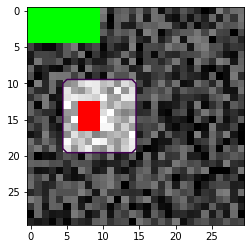

In [97]:
#More complex example without interactivity
import numpy as np
import imcut.pycut as pspc
import matplotlib.pyplot as plt

# create data
data = np.random.rand(5, 30, 30)
data[1:4, 10:20, 5:15] += 1
data = data * 30
data = data.astype(np.int16)
    
# Make seeds
seeds = np.zeros([5,30,30])
seeds[1:4, 13:17, 7:10] = 1
seeds[0:4, 0:5:, 0:10] = 2
    
# Run 
igc = pspc.ImageGraphCut(data, voxelsize=[1, 1, 1])
igc.set_seeds(seeds)
igc.run()
    
# Show results
colormap = plt.cm.get_cmap('brg')
colormap._init()
colormap._lut[:1:,3]=0
    
plt.imshow(data[3, :, :], cmap='gray') 
plt.contour(igc.segmentation[3,:, :], levels=[0.55])
plt.imshow(igc.seeds[3, :, :], cmap=colormap, interpolation='none')
plt.show()



In [98]:
def checkFolderExistenceAndCreate(folderPath):
    #if folderPath does not exist create it
    if os.path.exists(folderPath):
        #Check if it is a directory or not
        if os.path.isfile(folderPath): 
            sys.exit(folderPath, ' is a file and not directory. Exiting.') 
    else:
        #create 
        os.makedirs(folderPath)

In [99]:
def readAndScaleImageData(fileName, folderName, clipFlag, clipLow, clipHigh, scaleFlag, scaleFactor,\
                          meanSDNormalizeFlag, finalDataType, \
                          isLabelData, labels_to_train_list, verbose=False): 
    returnNow = False
    #check file existence
    filePath = os.path.join(folderName, fileName)            
    if os.path.exists(filePath):
        pass
    else:
        print(filePath, ' does not exist')  
        returnNow = True  
    if returnNow:
        sys.exit() 
    #We are here => returnNow = False
    #Also note #axes: depth, height, width
    fileData = np.transpose(nib.load(filePath).get_fdata(), axes=(2,1,0))  
    #Debug code
    if verbose:
        dataMin = fileData.min()
        dataMax = fileData.max()
        print('fileName - shape - type -min -max: ', fileName, ' ', fileData.shape, ' ', fileData.dtype, ' ', dataMin, ' ', dataMax)
    #Clamp                          
    if True == clipFlag:
        np.clip(fileData, clipLow, clipHigh, out= fileData)
    #Scale   
    if True == scaleFlag:
        fileData = fileData / scaleFactor
    #mean SD Normalization
    if True == meanSDNormalizeFlag:
        fileData = (fileData - np.mean(fileData))/np.std(fileData)
    #Type conversion
    fileData = fileData.astype(finalDataType)
    if True == isLabelData:
        # pick specific labels to train (if training labels other than 1s and 0s)
        if labels_to_train_list != [1]:
            temp = np.zeros(shape=fileData.shape, dtype=fileData.dtype)
            new_label_value = 1
            for lbl in labels_to_train_list: 
                ti = (fileData == lbl)
                temp[ti] = new_label_value
                new_label_value += 1
            fileData = temp
    return fileData

### Experiment plan : (a) 2D: change scribble fraction and dilation; select scribble in 2D, run imcut in 2D and plot graphcut result  (b) 3D: select change scribble fraction and dilation; select scribble in 3D, get bounding box  of gt;  run imcut in 3D and plot graphcut result 

In [100]:
#Run experiment on a patient

srcFolder = '/home/user/DMML/Data/HeadNeck_PET_CT/nnUnet_3dfullres/validation_gtvs_withSoftmax'
expFolder = '/home/user/DMML/Data/PlayDataManualSegmentation/AutoScribbleExperiment'
patientName = 'CHUM038'
ctSuffix = '_ct.nii.gz'
ptSuffix = '_pt.nii.gz'
gtSuffix = '_ct_gtvt.nii.gz'
predSuffix = '_segment.nii.gz'
softmaxSuffix = '_softMax.nii.gz'
expPatName = 'expPat'

ct_low = -1000 
ct_high = 3095 
pt_low = 0.0 
pt_high =  20.0 
labels_to_train = [1]
clipImages=False
scaleImages=False
normalizeImages=False
verbose=True


#Following code will go into a function

#check existence of destination folder
checkFolderExistenceAndCreate(expFolder)
#Transfer file into experiment directory with fixed name
shutil.copy(os.path.join(srcFolder, patientName+ctSuffix), \
            os.path.join(expFolder, expPatName+ctSuffix))
shutil.copy(os.path.join(srcFolder, patientName+ptSuffix), \
            os.path.join(expFolder, expPatName+ptSuffix))
shutil.copy(os.path.join(srcFolder, patientName+gtSuffix), \
            os.path.join(expFolder, expPatName+gtSuffix))
shutil.copy(os.path.join(srcFolder, patientName+predSuffix), \
            os.path.join(expFolder, expPatName+predSuffix))
shutil.copy(os.path.join(srcFolder, patientName+softmaxSuffix), \
            os.path.join(expFolder, expPatName+softmaxSuffix))

#Read np ndarray from the files, to scale or not to scale? 
ctFileName = expPatName+ctSuffix
ctData = readAndScaleImageData(fileName=ctFileName,\
    folderName=expFolder, clipFlag = clipImages,\
    clipLow=ct_low, clipHigh =ct_high,\
    scaleFlag=scaleImages, scaleFactor=1000, meanSDNormalizeFlag = normalizeImages, finalDataType = np.float32,\
    isLabelData=False, labels_to_train_list=None, verbose=verbose)

ptFileName = expPatName+ptSuffix
ptData = readAndScaleImageData(fileName=ptFileName,\
    folderName=expFolder, clipFlag = clipImages,\
    clipLow=pt_low, clipHigh =pt_high,\
    scaleFlag=scaleImages, scaleFactor=1, meanSDNormalizeFlag = normalizeImages, finalDataType = np.float32,\
    isLabelData=False, labels_to_train_list=None, verbose=verbose)

gtFileName = expPatName+gtSuffix
gtData = readAndScaleImageData(fileName=gtFileName,\
    folderName=expFolder, clipFlag = False,\
    clipLow=0, clipHigh = 0,\
    scaleFlag=False, scaleFactor=1, meanSDNormalizeFlag = False, finalDataType = np.int8, \
    isLabelData=True, labels_to_train_list=labels_to_train, verbose=verbose)

predFileName = expPatName+predSuffix
predData = readAndScaleImageData(fileName=predFileName,\
    folderName=expFolder, clipFlag = False,\
    clipLow=0, clipHigh = 0,\
    scaleFlag=False, scaleFactor=1, meanSDNormalizeFlag = False, finalDataType = np.int8, \
    isLabelData=True, labels_to_train_list=labels_to_train, verbose=verbose)

softmaxFileName = expPatName+softmaxSuffix
softmaxData = readAndScaleImageData(fileName=softmaxFileName,\
    folderName=expFolder, clipFlag = False,\
    clipLow=0.0, clipHigh =1.0,\
    scaleFlag=False, scaleFactor=1.0, meanSDNormalizeFlag = False, finalDataType = np.float32,\
    isLabelData=False, labels_to_train_list=None, verbose=verbose)



fileName - shape - type -min -max:  expPat_ct.nii.gz   (145, 144, 144)   float64   -1438.966064453125   4639.98291015625
fileName - shape - type -min -max:  expPat_pt.nii.gz   (145, 144, 144)   float64   -0.014495441690087318   8.463794708251953
fileName - shape - type -min -max:  expPat_ct_gtvt.nii.gz   (145, 144, 144)   float64   0.0   1.0
fileName - shape - type -min -max:  expPat_segment.nii.gz   (145, 144, 144)   float64   0.0   1.0
fileName - shape - type -min -max:  expPat_softMax.nii.gz   (145, 144, 144)   float64   0.0   1.0


In [101]:
# Code to write output in file
fractionDivider=5
dilation_diam=1

# #https://stackoverflow.com/questions/4260280/if-else-in-a-list-comprehension
# listOfSlicesWithGT = [sliceId for sliceId in range(gtData.shape[0]) if np.sum(gtData[sliceId,...]) >0]
# print(listOfSlicesWithGT
listOfSlicesWithGT, fgScribbleFromFGMissed, bgScribbleFromBGWrongC,\
 fgScribbleFromDefiniteFG, bgScribbleFromDefiniteBG \
 = autoGenerateScribbleRegions2D(gt=gtData, pred=predData, fractionDivider=fractionDivider, dilation_diam=dilation_diam)

#Wtite results in file
# #Transpose back to have same alignment as modelImage
#         pred_data = np.transpose(transposed_pred_data, axes=(2,1,0)).astype(np.int8)
#         desImage_nii = nib.Nifti1Image(pred_data, affine=modelImage_nii_aff)
#         nib.save(desImage_nii, destinationFilePath)
modelImage_nii_aff = nib.load(os.path.join(expFolder, ctFileName)).affine
expResFolder = os.path.join(expFolder,'fr_{:>02d}_D_{:>02d}'.format(fractionDivider, dilation_diam))
#check existence of destination folder
checkFolderExistenceAndCreate(expResFolder)
                          
fgScrM_name = expPatName + '_fgScrM_fr_{:>02d}_D_{:>02d}.nii.gz'.format(fractionDivider, dilation_diam)
fgScrM_path = os.path.join(expResFolder, fgScrM_name)
bgScrM_name = expPatName + '_bgScrM_fr_{:>02d}_D_{:>02d}.nii.gz'.format(fractionDivider, dilation_diam)
bgScrM_path = os.path.join(expResFolder, bgScrM_name)
fgScrD_name = expPatName + '_fgScrD_D_{:>02d}.nii.gz'.format(dilation_diam)
fgScrD_path = os.path.join(expResFolder, fgScrD_name)
bgScrD_name = expPatName + '_bgScrD_D_{:>02d}.nii.gz'.format(dilation_diam)
bgScrD_path = os.path.join(expResFolder, bgScrD_name)

nib.save(nib.Nifti1Image(np.transpose(fgScribbleFromFGMissed, axes=(2,1,0)),\
                         affine=modelImage_nii_aff),fgScrM_path)
nib.save(nib.Nifti1Image(np.transpose(bgScribbleFromBGWrongC, axes=(2,1,0)),\
                         affine=modelImage_nii_aff),bgScrM_path)
nib.save(nib.Nifti1Image(np.transpose(fgScribbleFromDefiniteFG, axes=(2,1,0)),\
                         affine=modelImage_nii_aff),fgScrD_path)
nib.save(nib.Nifti1Image(np.transpose(bgScribbleFromDefiniteBG, axes=(2,1,0)),\
                         affine=modelImage_nii_aff),bgScrD_path)

In [102]:
#Things to do quickly : 
#(a) check softmax structure - is it just forground probability or both? 
#(b) compute bounding box of GTV
#(c) Compute scribbles from the auto scribbles
#(d) Using scribbles and bounding box and foreground probability obtain graphcut segmentation
#(e) Experimental loop to tweak scribble generation and graphcut segmentation
#(b) Check if all images are of size (144,144,144) or if some has 145 slices